### [EIO] K-Means algorithm

#### Daniel Zdancewicz - grupa L9 (indeks: 145317)

##### Homework

* Write your own implementation of k-means algorithm:
  * With random centroid initialization.
  * Stopping condition max iterations.
  * Stopping condition centroid convergence: (if all attributes of all centroids changes not more than some epsilon the algorithm should stop).
* Use your implementation to cluster data containing data about cereal products with their dietary characteristics (cereals.csv, 16 attributes). 
* It contains some nominal attributes (name, mfr, type).
  * You can omit the first two of them.
  * Type attribute is binary, so you can replace it with values 0 and 1.
* Perform the clustering of the cereals into 3 groups using k-means algorithm. 
* Remember to preprocess the given input: normalization/standardisation, attribute selection.

Try to describe the obtained groups based on the obtained centroids, what do all cereals within this group have in common?
Write a report containing information about used preprocessing methods, number of cereals within each cluster and your conclusions about the clustering results.

**Deadline +2 weeks**

### Imports

In [244]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.preprocessing as skp
import sklearn.cluster as skc
import sklearn.feature_selection as skfs

### K-means implementation

In [245]:
def k_means(points, /, *, n_clusters: int, iterations: int, tolerance: float):
  def distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2, axis=1))

  centroids = np.random.uniform(
    np.min(points, axis=0),
    np.max(points, axis=0),
    size=(n_clusters, points.shape[1])
  )

  labels = []
  previous = centroids
  for i in range(iterations):
    labels = np.argmin([
      distance(centroid, points) for centroid in centroids
    ], axis=0)

    centroids = np.array([
      np.mean(points[labels == label], axis=0)
      if np.sum(labels == label)
      else centroids[label]
      for label in range(n_clusters)
    ])

    if np.all(np.abs(previous - centroids) < tolerance):
      print(f"k-means algorithm early stopped at: {i}")
      break
    previous = centroids
  return (labels, centroids)


### Correctness verification

Scikit-Learn K-Means:


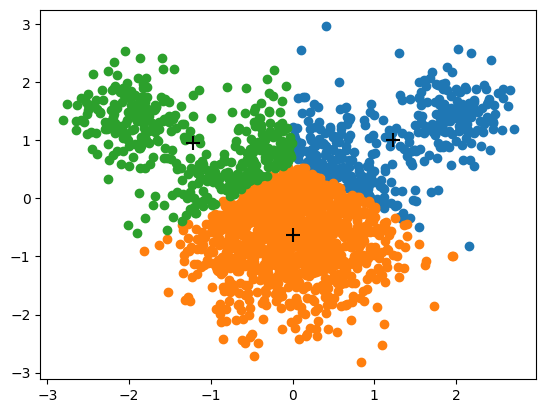

Implemented K-Means:
k-means algorithm early stopped at: 27


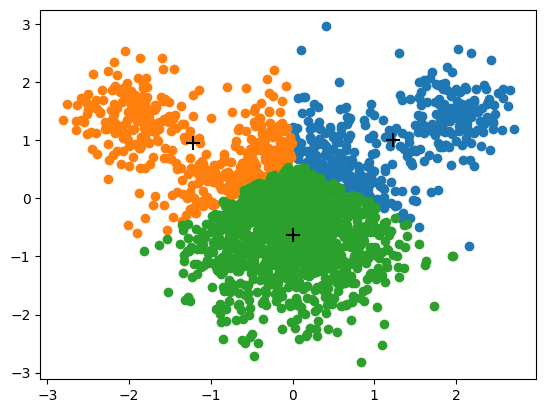

In [246]:
def preprocess(points):
  return skp.StandardScaler().fit_transform(points)

def read_file(path: str):
  with open(path) as file:
    return preprocess(tuple(csv.reader(file)))


def show_clusters(clusters, centroids):
  for cluster in clusters: plt.scatter(*zip(*cluster))
  plt.scatter(*zip(*centroids), marker='+', color='black', s=100)
  plt.show()

def fit_kmeans_scikit(points, /, *, n_clusters: int, iterations: int, tolerance: float):
  kmeans = skc.KMeans(n_clusters=n_clusters, max_iter=iterations, tol=tolerance).fit(points)
  (labels, centroids) = kmeans.labels_, kmeans.cluster_centers_

  clusters = [[] for _ in range(n_clusters)]
  for (i, label) in enumerate(labels):
    clusters[label].append(points[i])

  return (clusters, centroids)

def fit_kmeans_impl(points, /, *, n_clusters: int, iterations: int, tolerance: float):
  (labels, centroids) = k_means(points, n_clusters=n_clusters, iterations=iterations, tolerance=tolerance)

  clusters = [[] for _ in range(n_clusters)]
  for (index, label) in enumerate(labels):
    clusters[label].append(points[index])

  return (clusters, centroids)

points = read_file("resources/mouse.csv")
metaparams = {"n_clusters": 3, "iterations": 100, "tolerance": 1e-6}

print(f"Scikit-Learn K-Means:")
show_clusters(*fit_kmeans_scikit(points, **metaparams))
print(f"Implemented K-Means:")
show_clusters(*fit_kmeans_impl(points, **metaparams))

### 3. Cereal dataset analysis

In [247]:
df = pd.read_csv("resources/cereal.csv")
df = df.drop(columns=["name", "mfr"])
df.type = df.type.map({"C": 0, "H": 1})
df.head()

,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,0,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,0,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,0,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,0,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [248]:
df.nunique(axis=0)

type         2
calories    11
protein      6
fat          5
sodium      27
fiber       13
carbo       22
sugars      17
potass      36
vitamins     3
shelf        3
weight       7
cups        12
rating      77
dtype: int64

In [249]:
normalized = skp.MinMaxScaler().fit_transform(df)
normalized = pd.DataFrame(normalized, columns=df.columns)
threshold = skfs.VarianceThreshold(threshold=0.03).fit(normalized)


In [278]:
metaparams = {"n_clusters": 3, "iterations": 100, "tolerance": 1e-6}
(labels, centroids) = k_means(normalized, **metaparams)

counts = np.asarray(np.unique(labels, return_counts=True)).T
print(f"""
Number of cereals within each cluster:
 {counts}

Labels:
 {labels}

Centroids:
""")
for (centroid, descriptor) in enumerate(map(lambda centroid: zip(normalized.columns, centroid), centroids)):
  print(f"- Centroid No. '{centroid}'")
  for (column, value) in descriptor:
    print(f"  - {column: <10}: {value*100:.2f}%")
    if (value > 0.5): print(column)
  print()


k-means algorithm early stopped at: 9

Number of cereals within each cluster:
 [[ 0 36]
 [ 1 20]
 [ 2 21]]

Labels:
 [0 0 0 0 0 1 1 0 2 0 1 2 1 0 1 2 2 1 1 0 2 0 0 0 1 1 2 0 0 1 1 1 0 0 0 1 1
 1 0 0 2 0 1 2 0 0 0 2 1 0 0 0 0 0 2 2 0 2 0 0 0 2 2 2 2 2 1 2 2 0 0 0 0 1
 2 2 1]

Centroids:

- Centroid No. '0'
  - type      : 0.00%
  - calories  : 55.56%
calories
  - protein   : 39.44%
  - fat       : 26.67%
  - sodium    : 52.69%
sodium
  - fiber     : 23.61%
  - carbo     : 64.93%
carbo
  - sugars    : 50.17%
sugars
  - potass    : 41.79%
  - vitamins  : 36.81%
  - shelf     : 97.22%
shelf
  - weight    : 59.58%
weight
  - cups      : 36.80%
  - rating    : 34.48%

- Centroid No. '1'
  - type      : 0.00%
  - calories  : 55.91%
calories
  - protein   : 10.00%
  - fat       : 20.00%
  - sodium    : 53.12%
sodium
  - fiber     : 3.57%
  - carbo     : 56.25%
carbo
  - sugars    : 78.44%
sugars
  - potass    : 13.52%
  - vitamins  : 25.00%
  - shelf     : 35.00%
  - weight    : 50.00%
  - cup